<center>
    <h1>Fruit Inspection - Final Challenge: Kiwi Inspection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

The final challenge considers the images in the folder `images/final challenge/`, that illustrate five different kiwis.

| NIR example                   | Colour example                |
|:-----------------------------:|:-----------------------------:|
| 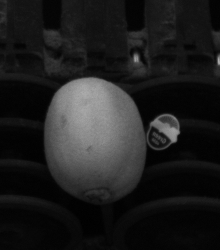 | 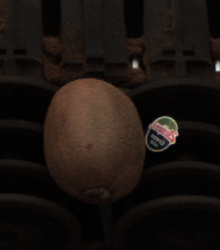 |

It is required to localize eventual defects on the fruits.

*Note: special care should be taken to remove as "background" the dirt on the conveyor as well as the sticker in image `C1_000006`.*

#### Procedure
Although this is an academic project, the working pipeline has been developed considering an industrial setting where the inspection of the fruits has to be carried out by an *online* system. A set of methods have been tested in terms of quality, speed and robustness.

# 00 Prerequisites
The libraries necessary for the task are imported.

In [1]:
%matplotlib inline

import cv2 as cv
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.spatial.distance import cdist
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
from time import time

# Utils libraries
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [2]:
print(f'Using OpenCV version: {cv.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [3]:
SEED = 42

cv.setRNGSeed(SEED)
np.random.seed(SEED)

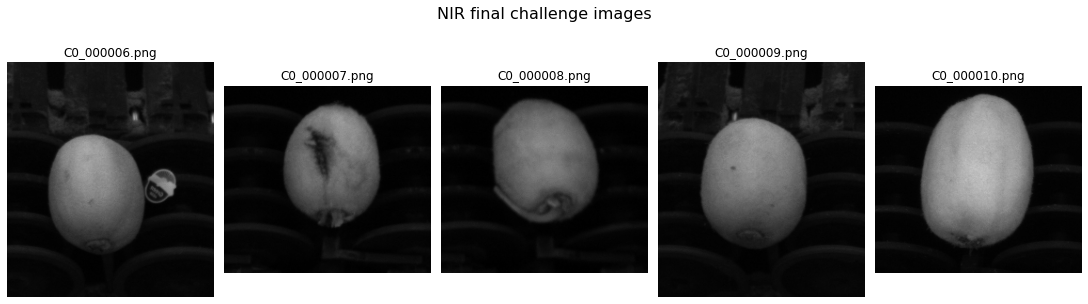

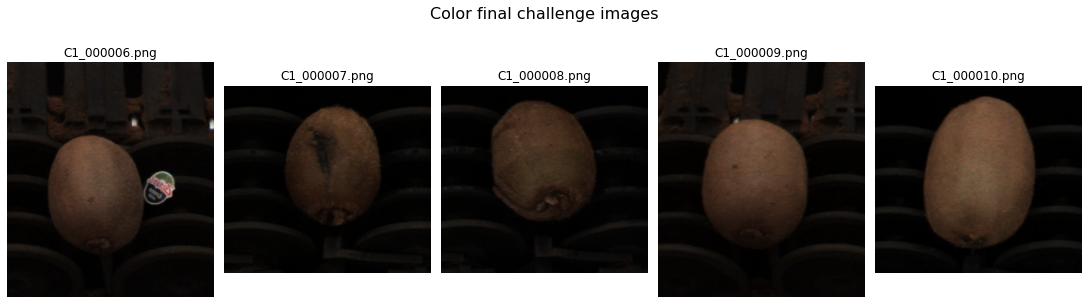

In [4]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, colour_names = [[f'C{j}_{str(i).zfill(6)}.png' for i in range(6,11)] for j in [0,1]]

# Directory where the images are saved
DIR = '../images/final challenge/'

# Import NIR and color images
nir_imgs = [cv.imread(f'{DIR}{img}', cv.IMREAD_GRAYSCALE) for img in nir_names]
colour_imgs = [cv.imread(f'{DIR}{img}') for img in colour_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, nir_names, 'NIR final challenge images')
plot_image_grid(colour_imgs, colour_names, 'Color final challenge images')

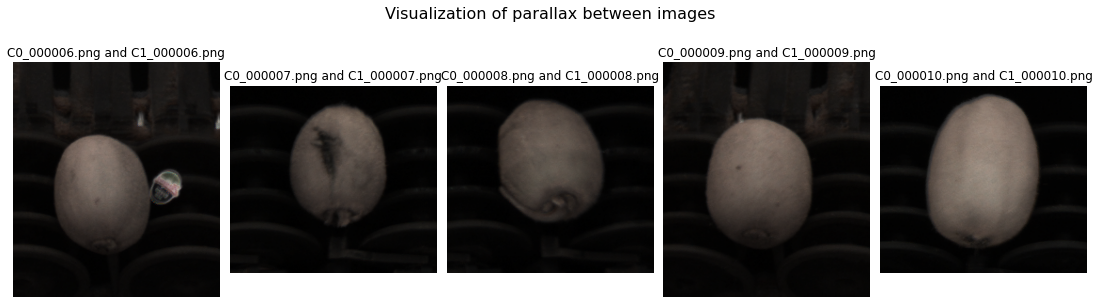

In [5]:
parallaxes = [cv.addWeighted(cv.cvtColor(n, cv.COLOR_GRAY2BGR), 0.5, c, 0.5, 0) 
              for n, c in zip(nir_imgs, colour_imgs)]

plot_image_grid(parallaxes, [f'{n} and {c}' for n, c in zip(nir_names, colour_names)], 
                'Visualization of parallax between images')

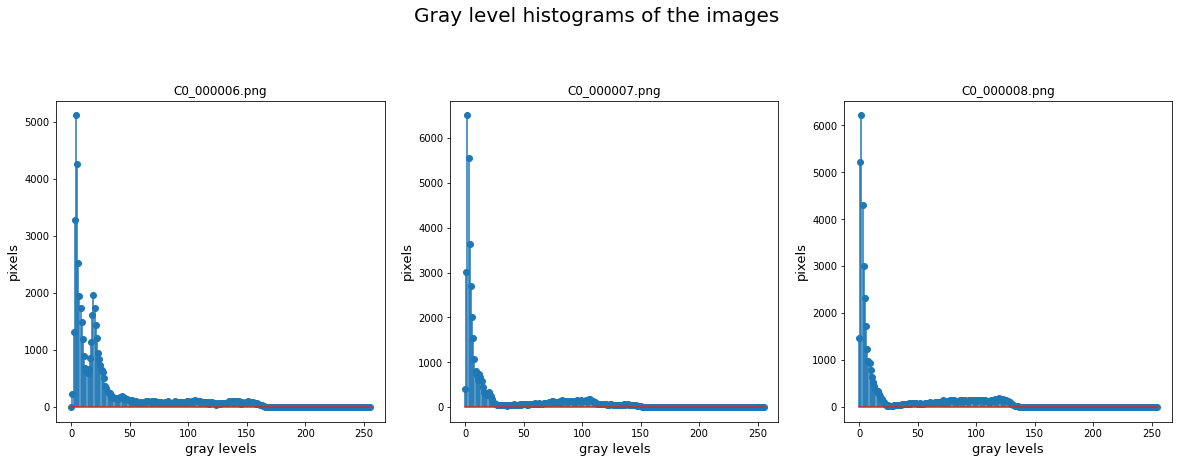

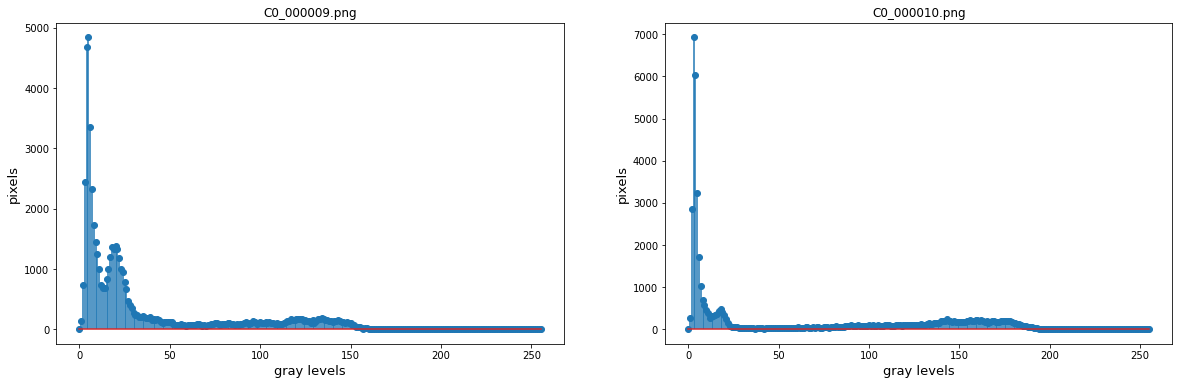

In [6]:
plot_histogram_grid(nir_imgs[:3], nir_names[:3], 'Gray level histograms of the images')
plot_histogram_grid(nir_imgs[3:], nir_names[3:], '')

In [7]:
'''equalized_nir_imgs = [cv.equalizeHist(img) for img in nir_imgs]
plot_image_grid(equalized_nir_imgs, nir_names, 'Equalized NIR images')'''

"equalized_nir_imgs = [cv.equalizeHist(img) for img in nir_imgs]\nplot_image_grid(equalized_nir_imgs, nir_names, 'Equalized NIR images')"

Images are equalized because compared to the grayscale images of previous tasks, the range of poorly used histogram intensities is larger ($[150, 255]$)

In [8]:
'''filtered_nir_images = [cv2.medianBlur(img,7) for img in equalized_nir_imgs]
plot_image_grid(filtered_nir_images, nir_names, 'Equalized NIR images')'''

"filtered_nir_images = [cv2.medianBlur(img,7) for img in equalized_nir_imgs]\nplot_image_grid(filtered_nir_images, nir_names, 'Equalized NIR images')"

In [9]:
filtered_nir_images = [cv2.medianBlur(img,7) for img in nir_imgs]

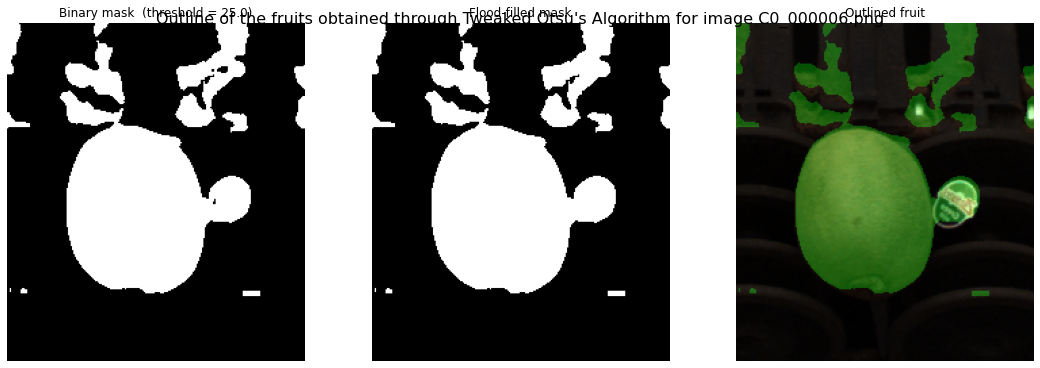

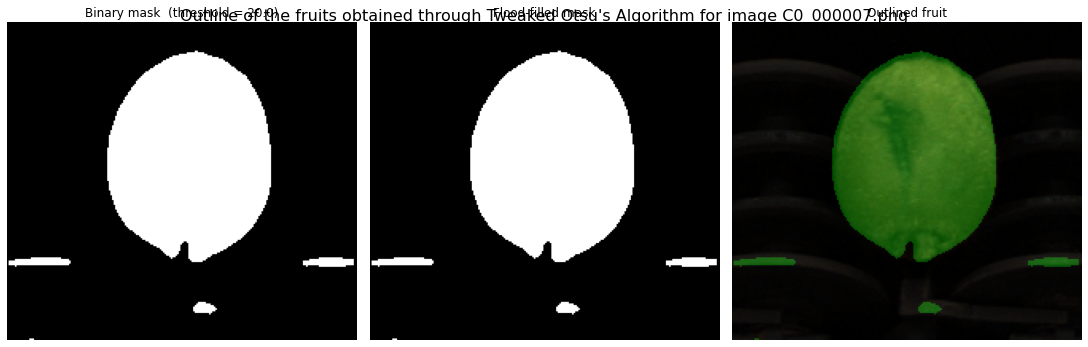

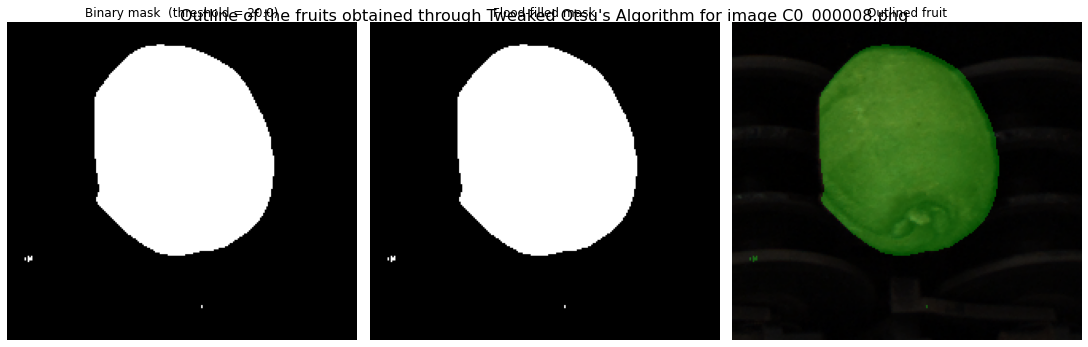

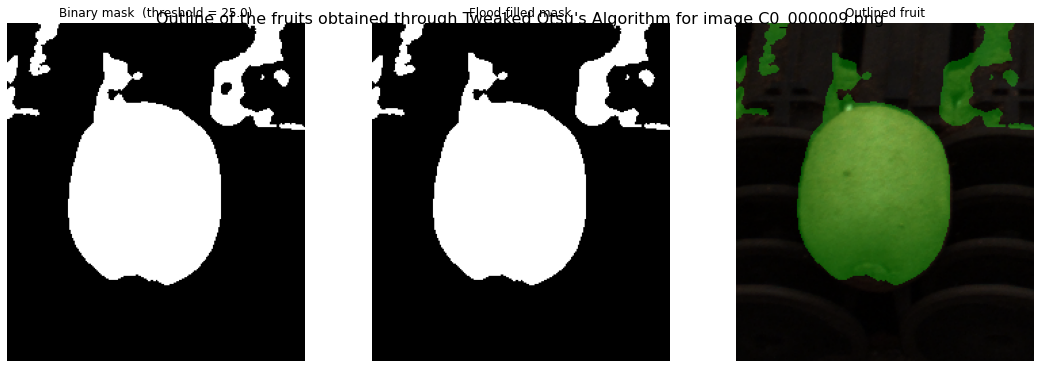

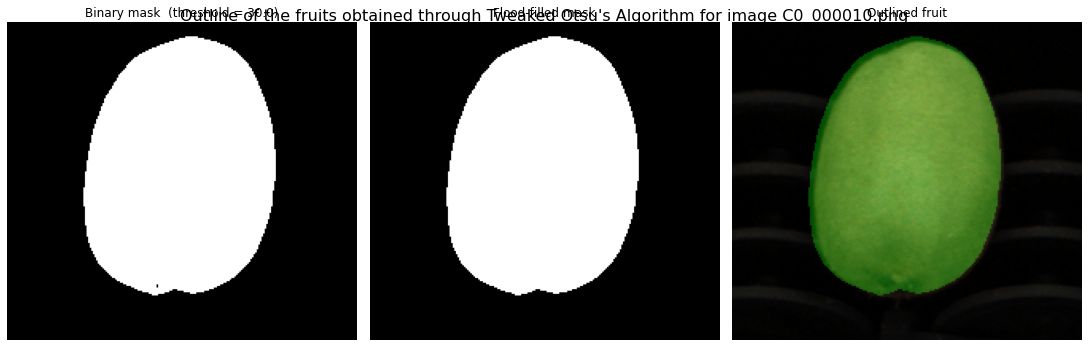

In [10]:
TWEAK_FACTOR = .4

plot_masking_process(filtered_nir_images, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

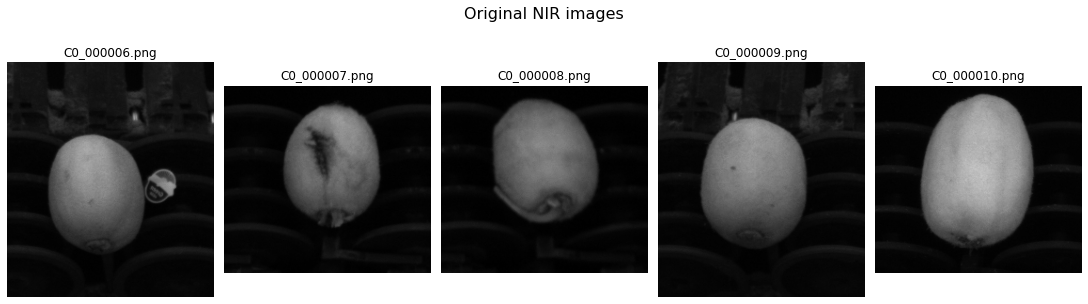

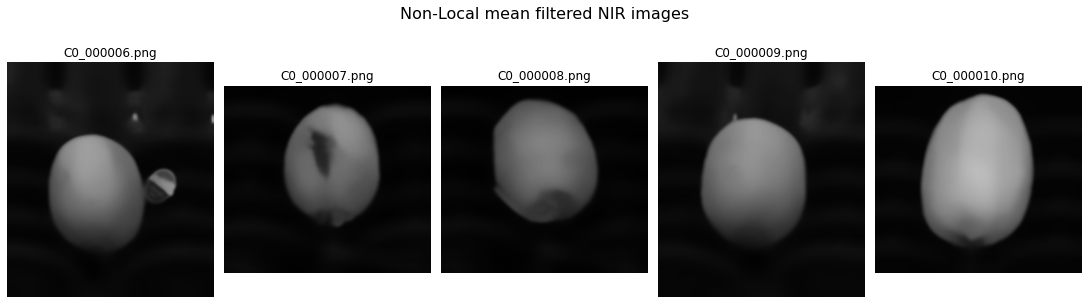

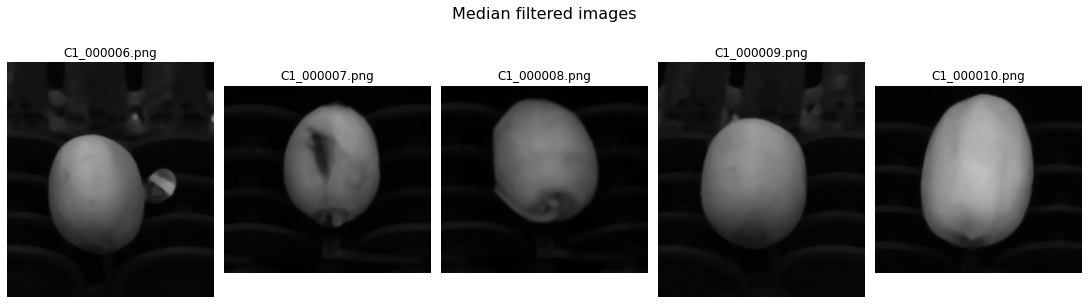

In [11]:
nl_filtered_imgs = [cv.fastNlMeansDenoising(img, h=25) for img in nir_imgs]
plot_image_grid(nir_imgs, nir_names, 'Original NIR images')
plot_image_grid(nl_filtered_imgs, nir_names, 'Non-Local mean filtered NIR images')
plot_image_grid(filtered_nir_images, colour_names, 'Median filtered images')

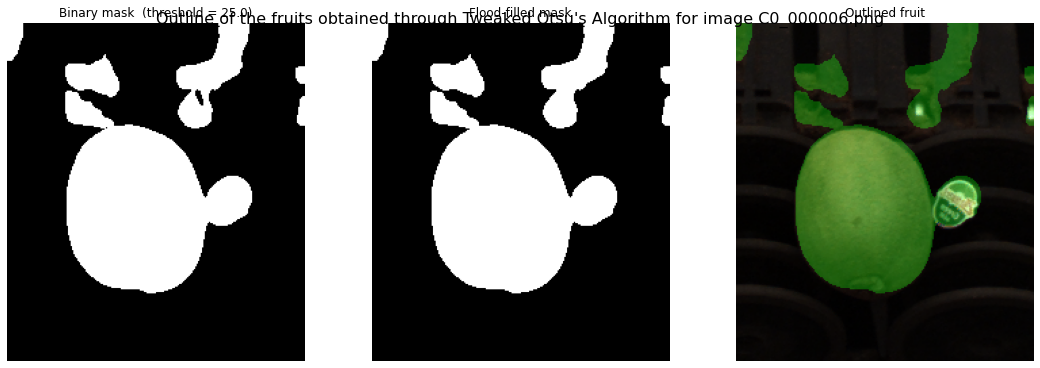

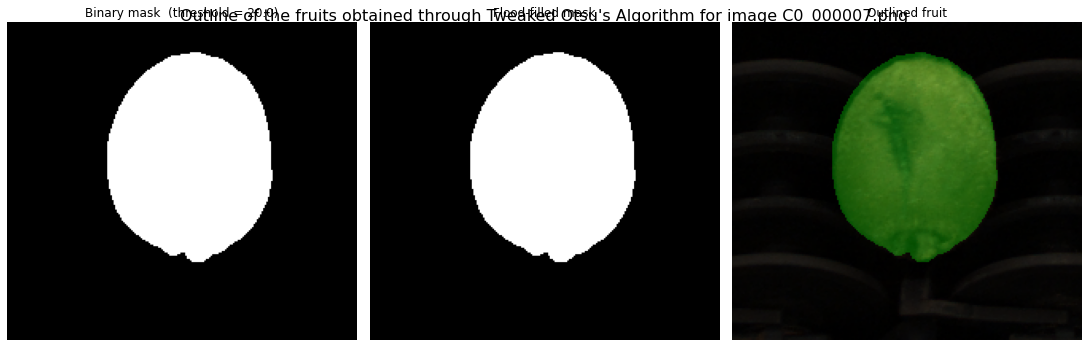

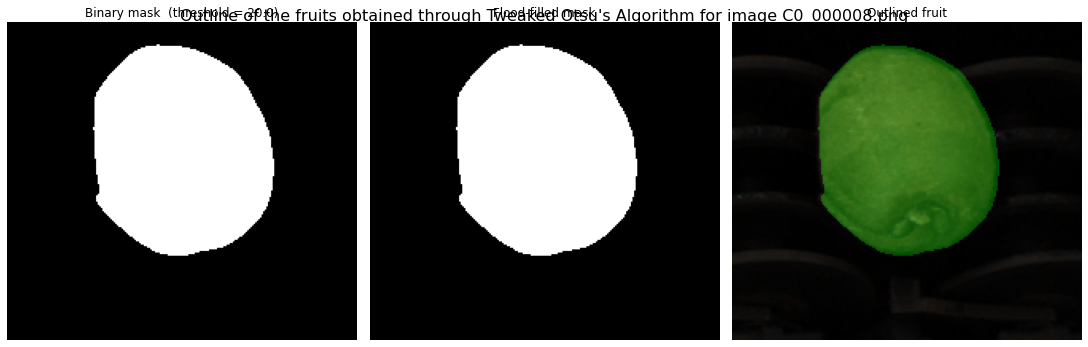

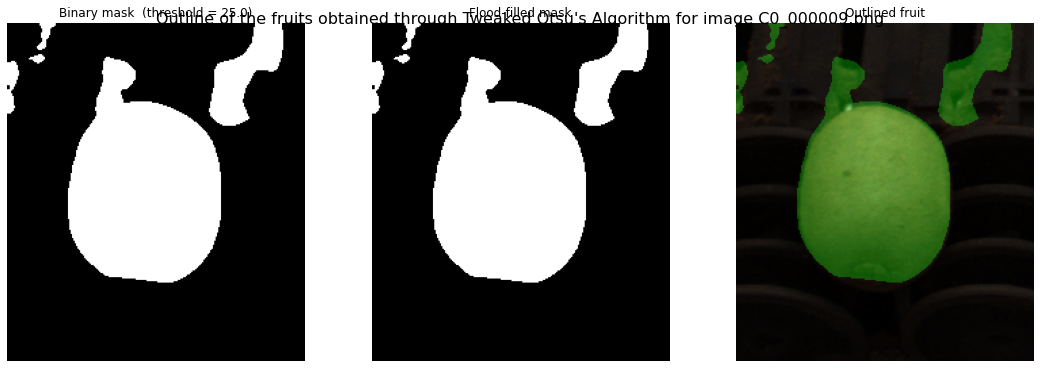

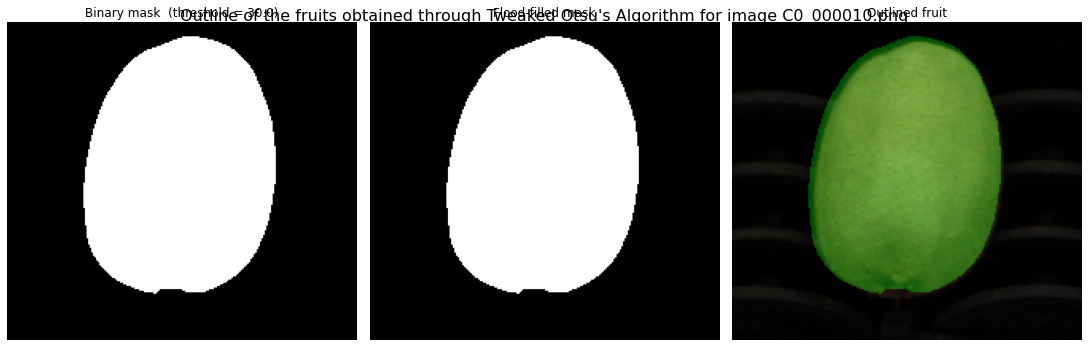

In [12]:
TWEAK_FACTOR = .4 #.5

plot_masking_process(nl_filtered_imgs, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

In [13]:
'''s = time()
for img in nir_imgs * 100:
    cv.medianBlur(img,7)
median_time = time() - s

s = time()
for img in nir_imgs * 100:
    cv.fastNlMeansDenoising(img, h=25)
nl_denoising_time = time() - s''';

In [14]:
'''print(f'Time for preprocessing {100 * len(colour_imgs)} images with a median filter: {median_time:.6f}')
print(f'Mean time for preprocessing an image with a median filter: {(median_time / (100 * len(colour_imgs))):.6f}')
print()

print(f'Time for preprocessing {100 * len(colour_imgs)} images with a non-local mean filter: {nl_denoising_time:.6f}')
print(f'Mean time for preprocessing an image with a non-local mean filter: {(nl_denoising_time / (100 * len(colour_imgs))):.6f}')''';

In [15]:
#filtered_nir_images

In [16]:
masks = [get_fruit_mask(img, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR) for img in filtered_nir_images]

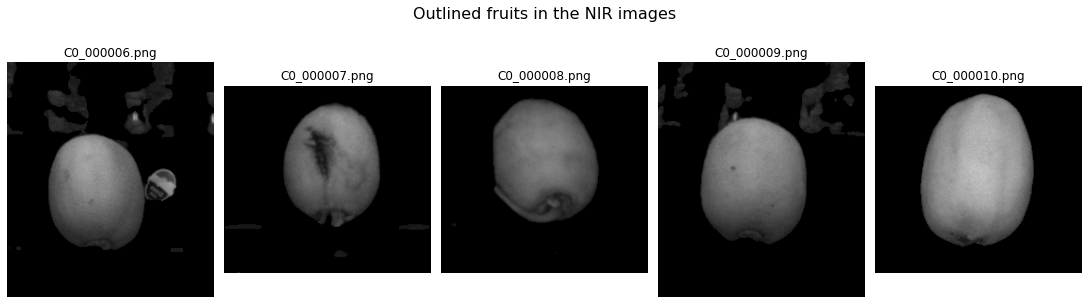

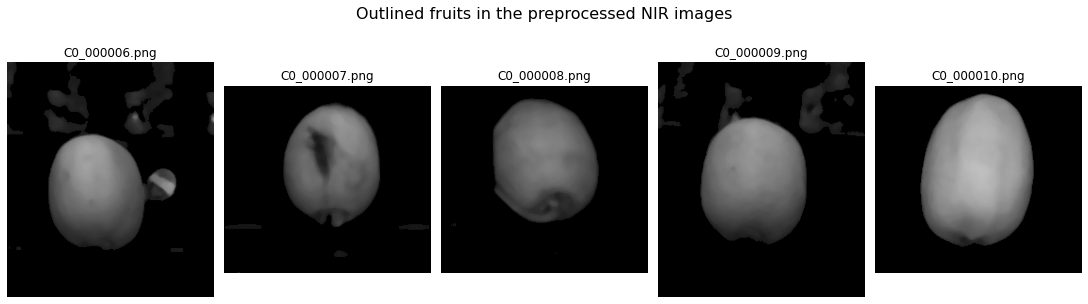

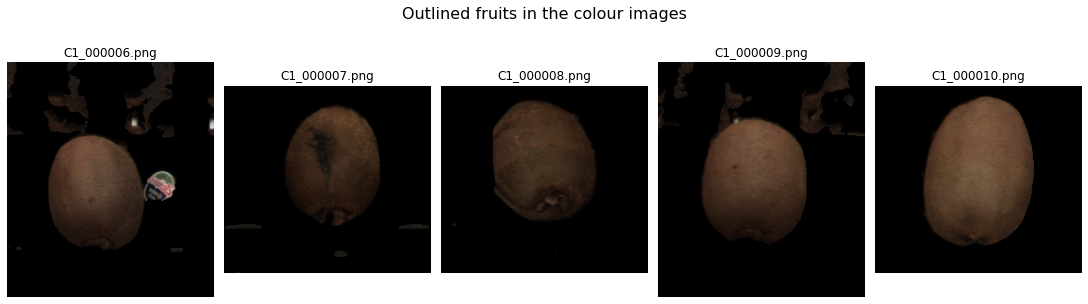

In [17]:
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]
masked_filtered_imgs = [filtered_nir_images[i] & masks[i] for i in range(len(masks))]
masked_colour_imgs = [colour_imgs[i] &  cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_filtered_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')
plot_image_grid(masked_colour_imgs, colour_names, 'Outlined fruits in the colour images')

In [18]:
s = time()
for i in range(100):
    se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,10))
    masks1 = [cv2.morphologyEx(m, cv2.MORPH_OPEN, se1) for m in masks]
    masked_nir_imgs1 = [nir_imgs[i] & masks1[i] for i in range(len(masks))]
total_time = time() - s

print(f'Total time taken: {total_time}')
print(f'Mean time per img: {total_time / (len(nir_imgs) *100)}')
#masks = [cv2.morphologyEx(m, cv2.MORPH_CLOSE, se2) for m in masks]

Total time taken: 0.7380015850067139
Mean time per img: 0.0014760031700134276


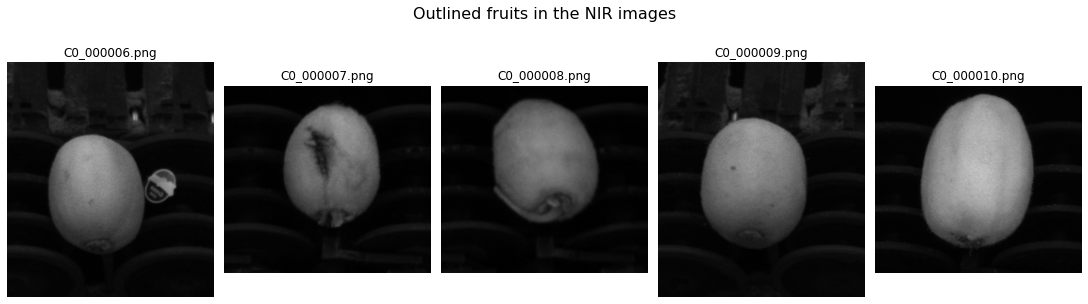

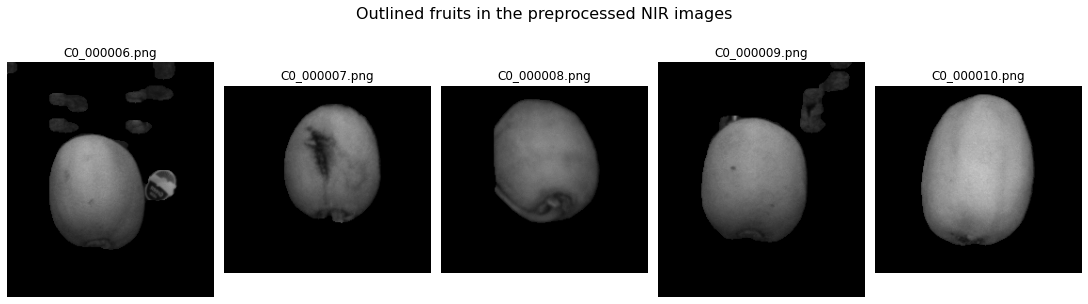

In [19]:
se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,10))
masks = [cv2.morphologyEx(m, cv2.MORPH_OPEN, se1) for m in masks]
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]
plot_image_grid(nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')

In [20]:
def get_largest_blob_mask(img):
    cnts, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv.contourArea)

    # Output
    out = np.zeros(img.shape, np.uint8)
    return cv.drawContours(out, [cnt], -1, 255, cv.FILLED)

In [21]:
def apply_mask_to_img(img, mask):
    if len(img.shape) == 3:
        mask = cv.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    return img & mask

In [22]:
masks = [get_largest_blob_mask(m) for m in masks]

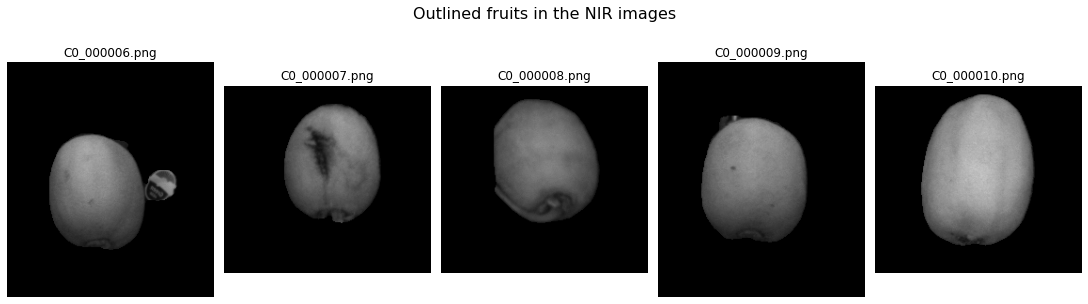

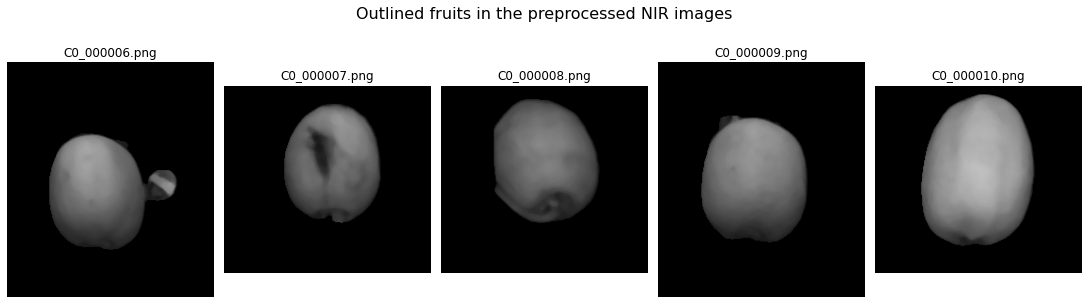

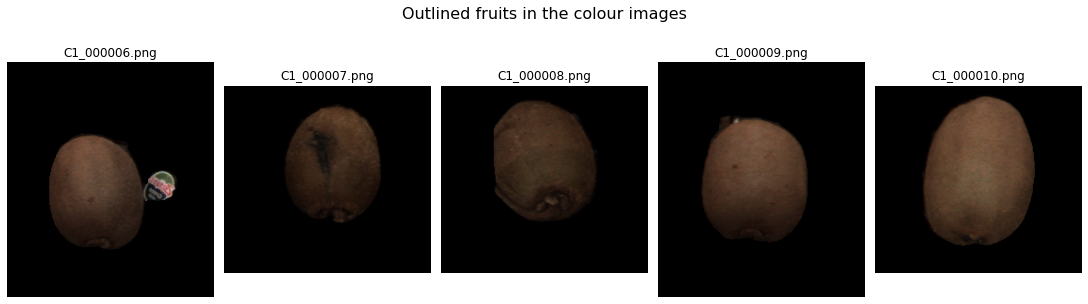

In [23]:
masked_nir_imgs = [apply_mask_to_img(img, m) for img, m in zip(nir_imgs, masks)]
masked_filtered_imgs = [apply_mask_to_img(img, m) for img, m in zip(filtered_nir_images, masks)]
masked_colour_imgs = [apply_mask_to_img(img, m) for img, m in zip(colour_imgs, masks)]

plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_filtered_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')
plot_image_grid(masked_colour_imgs, colour_names, 'Outlined fruits in the colour images')

In [50]:
filtered_masked_colour_imgs = [cv.medianBlur(img,5) for img in masked_colour_imgs]

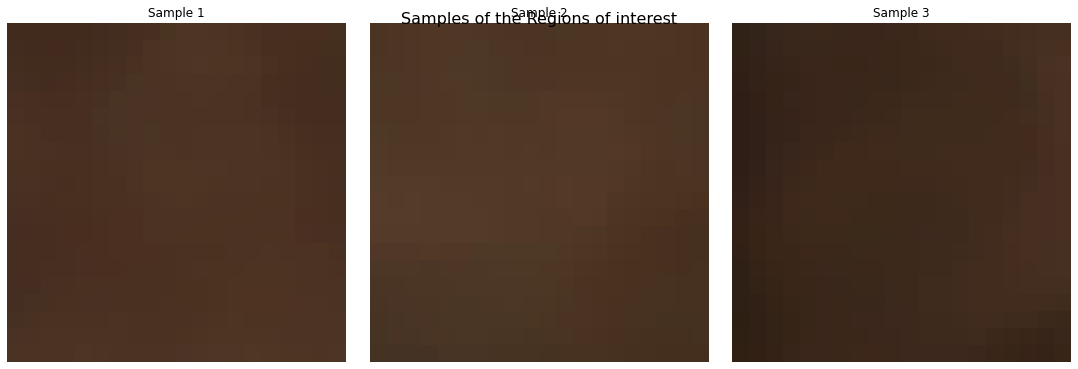

In [51]:
NUM_PATCHES = 200
PATCH_SIZE = 20

samples = get_samples(filtered_masked_colour_imgs[2], NUM_PATCHES, PATCH_SIZE)
samples += get_samples(filtered_masked_colour_imgs[4], NUM_PATCHES, PATCH_SIZE)

plot_image_grid([samples[0], samples[PATCH_SIZE], samples[PATCH_SIZE*2]], 
                [f'Sample {i}' for i in range(1,4)],
                'Samples of the Regions of interest')

In [48]:
lab_colour_space = ColourSpace('LAB')

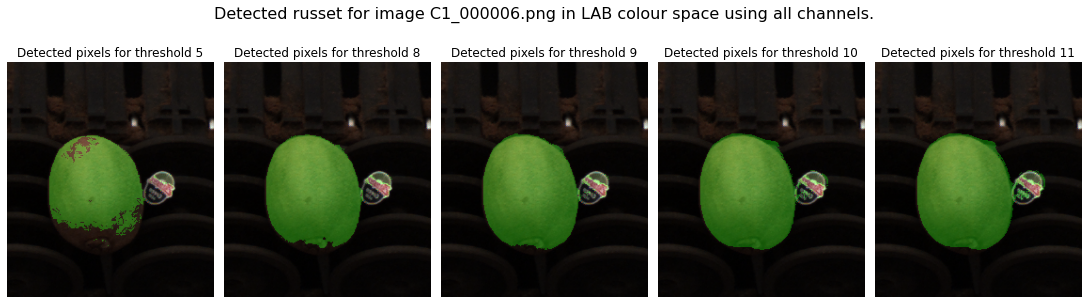

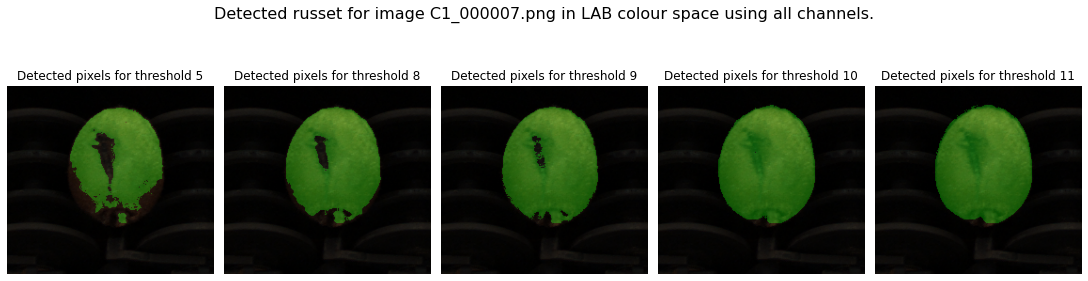

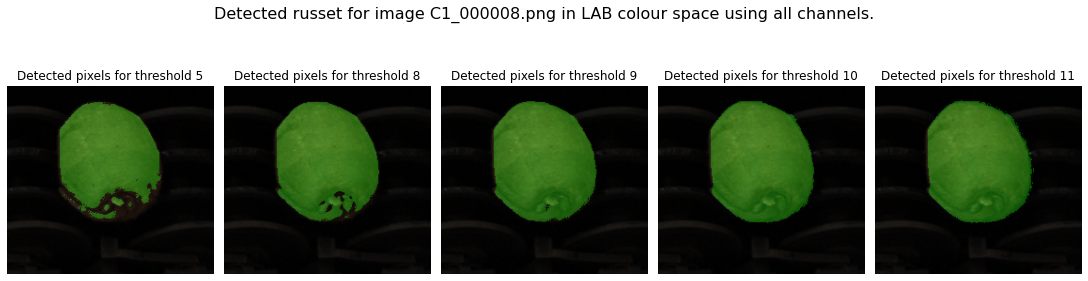

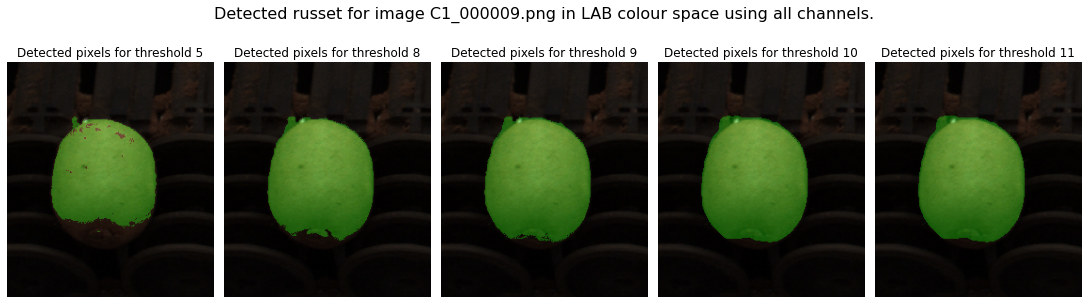

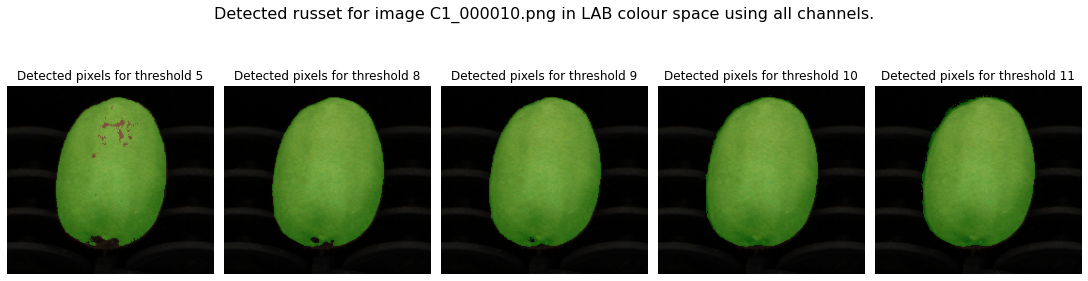

In [52]:
thresholds = [5, 8, 9, 10, 11]
mean, inv_cov = get_mean_and_inverse_covariance_matrix(samples, lab_colour_space, channels=(1, 2))
for idx, img in enumerate(filtered_masked_colour_imgs):
    plot_mahalanobis_results(lab_colour_space.bgr_to_color_space(img), colour_imgs[idx], mean, inv_cov, thresholds, 
                             f'Detected russet for image {colour_names[idx]} in LAB colour space using all channels.', 
                             channels=(1, 2))

In [53]:
lab_imgs = [lab_colour_space.bgr_to_color_space(img) for img in filtered_masked_colour_imgs]
masks = [get_mahalanobis_distance_img(img, mean, inv_cov, 10, (1, 2)) for img in lab_imgs]

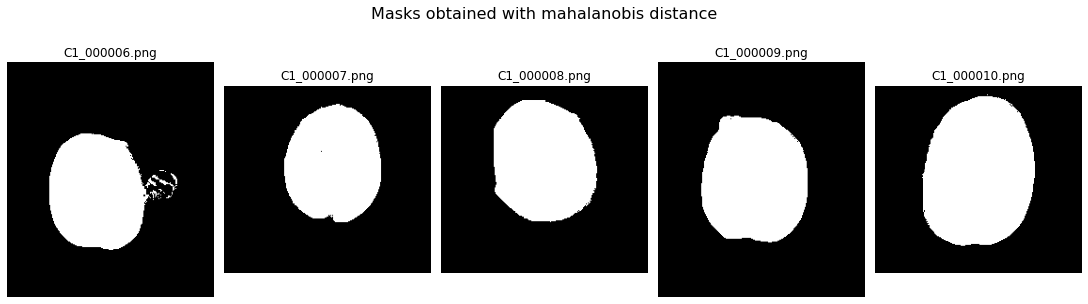

In [54]:
plot_image_grid(masks, colour_names, 'Masks obtained with mahalanobis distance')

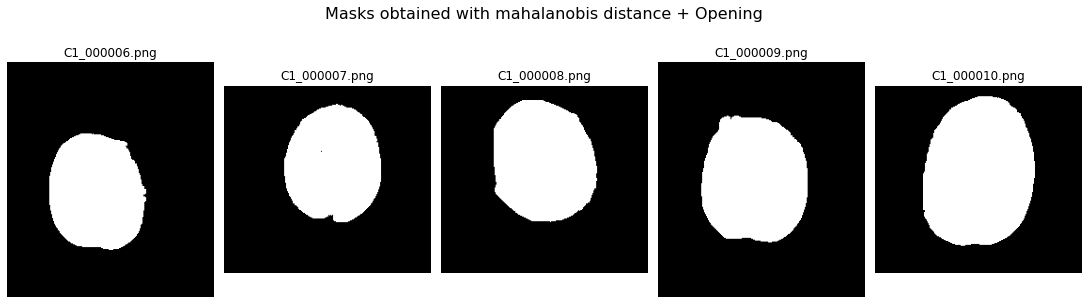

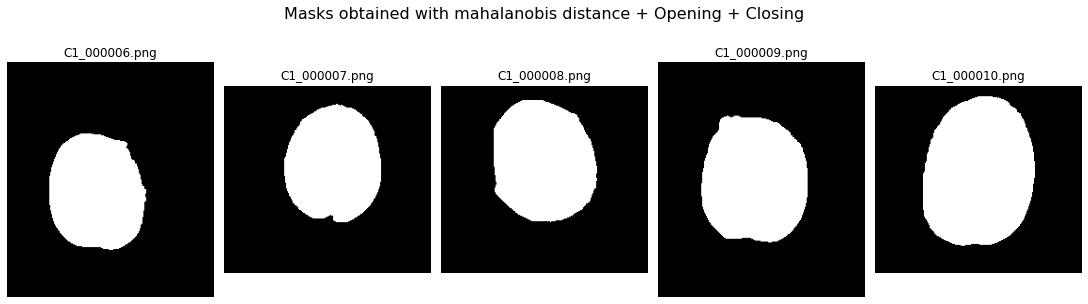

In [55]:
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
masks = [cv2.morphologyEx(m, cv2.MORPH_OPEN, se) for m in masks]
plot_image_grid(masks, colour_names, 'Masks obtained with mahalanobis distance + Opening')
masks = [cv2.morphologyEx(m, cv2.MORPH_CLOSE, se) for m in masks]
plot_image_grid(masks, colour_names, 'Masks obtained with mahalanobis distance + Opening + Closing')

In [91]:
masked_nir_imgs = [apply_mask_to_img(img, m) for img, m in zip(filtered_nir_images, masks)]

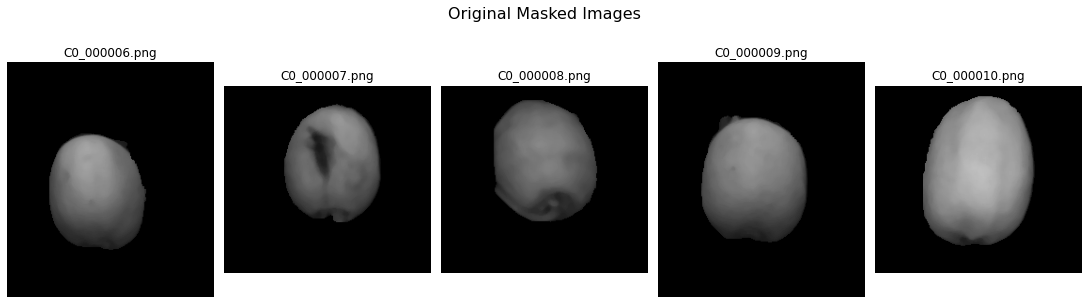

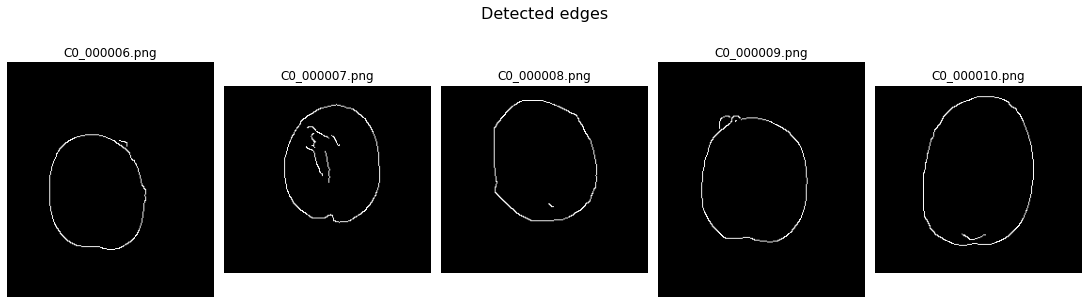

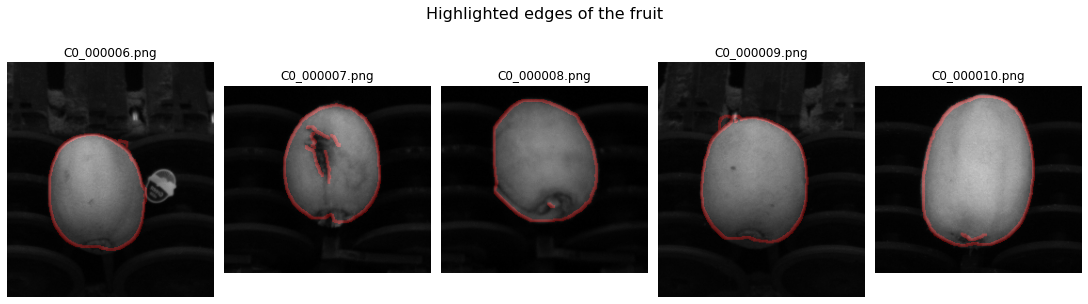

In [100]:
SIGMA = 1
THRESHOLD_1 = 50
THRESHOLD_2 = 85

edge_masks = [apply_gaussian_blur_and_canny(img, SIGMA, THRESHOLD_1, THRESHOLD_2) for img in masked_nir_imgs]
highlighted_edges_images = [get_highlighted_edges_on_image(img, e) for img, e in zip(nir_imgs, edge_masks)]

plot_image_grid(masked_nir_imgs, nir_names, 'Original Masked Images')
plot_image_grid(edge_masks, nir_names, 'Detected edges')
plot_image_grid(highlighted_edges_images, nir_names, 'Highlighted edges of the fruit')

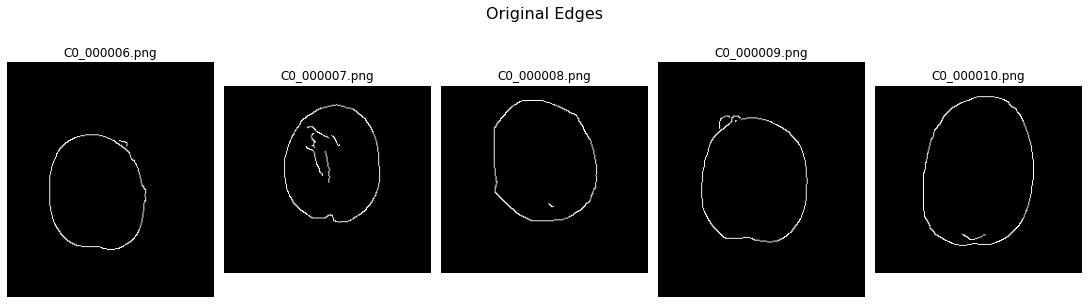

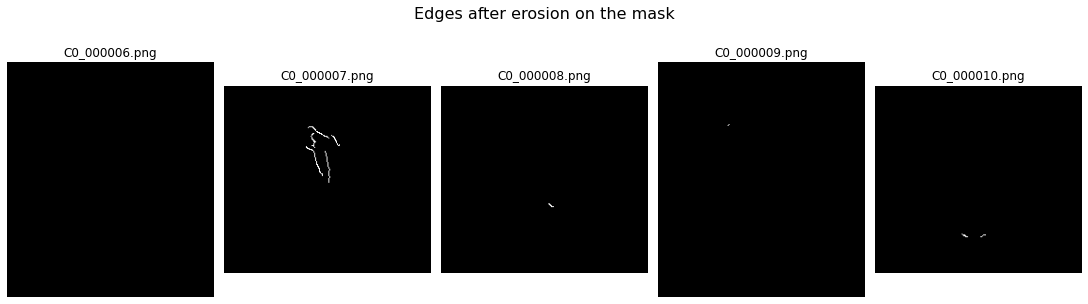

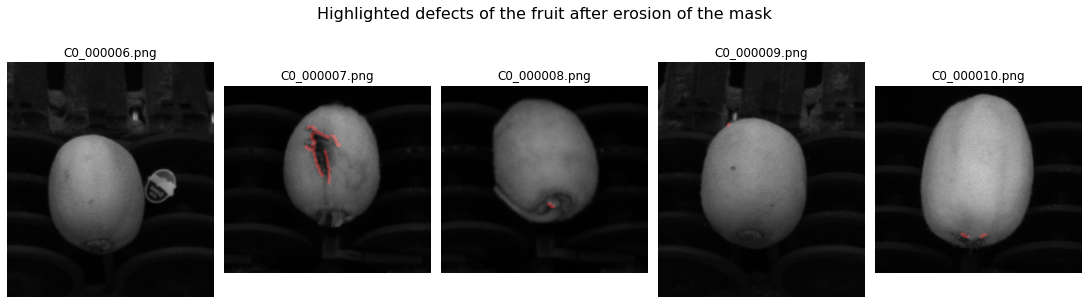

In [101]:
element = cv.getStructuringElement(cv.MORPH_RECT, (15, 15))
eroded_masks = [cv.erode(img, element) for img in masks]
eroded_edge_masks = [edge_masks[i] &  eroded_masks[i] for i in range(len(masks))]
highlighted_edges_images = [get_highlighted_edges_on_image(img, e) for img, e in zip(nir_imgs, eroded_edge_masks)]

plot_image_grid(edge_masks, nir_names, 'Original Edges')
plot_image_grid(eroded_edge_masks, nir_names, 'Edges after erosion on the mask')
plot_image_grid(highlighted_edges_images, nir_names, 'Highlighted defects of the fruit after erosion of the mask')

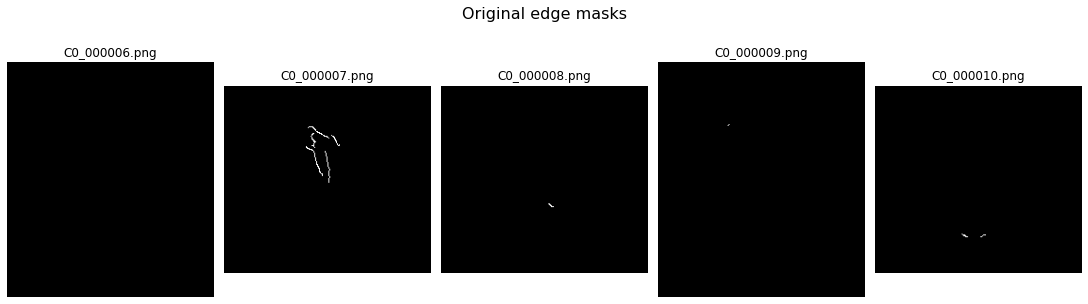

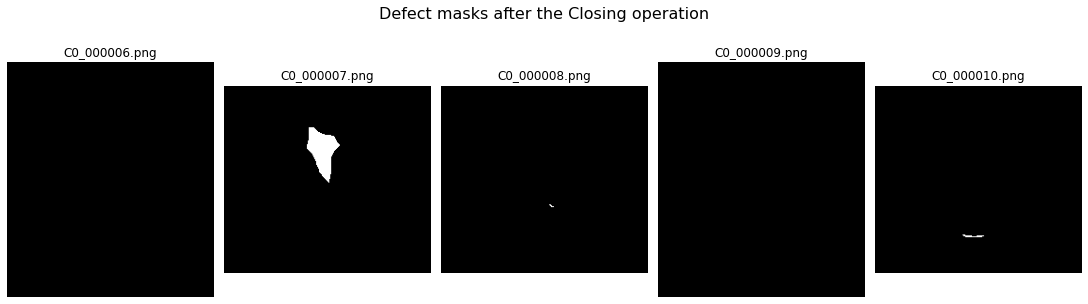

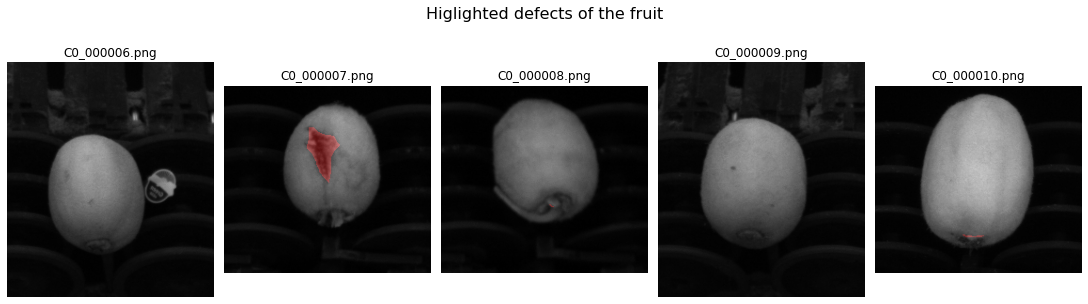

In [102]:
element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (50, 50))
defect_masks = [cv.morphologyEx(img, cv.MORPH_CLOSE, element) for img in eroded_edge_masks]
highlighted_defects = [get_highlighted_roi_by_mask(img, e, 'red') for img, e in zip(nir_imgs, defect_masks)]

plot_image_grid(eroded_edge_masks, nir_names, 'Original edge masks')
plot_image_grid(defect_masks, nir_names, 'Defect masks after the Closing operation')
plot_image_grid(highlighted_defects, nir_names, 'Higlighted defects of the fruit')

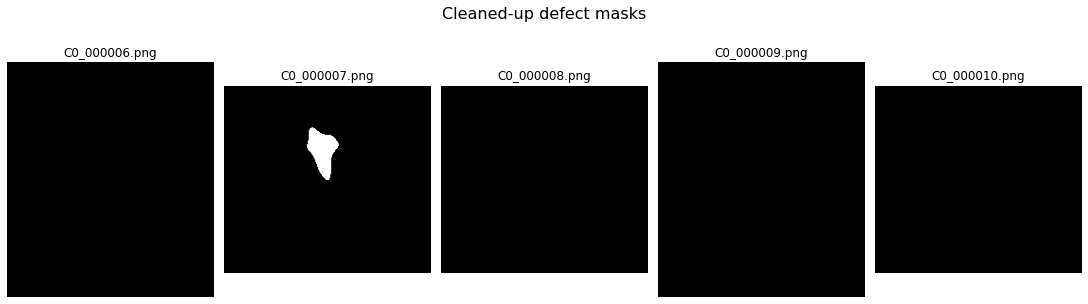

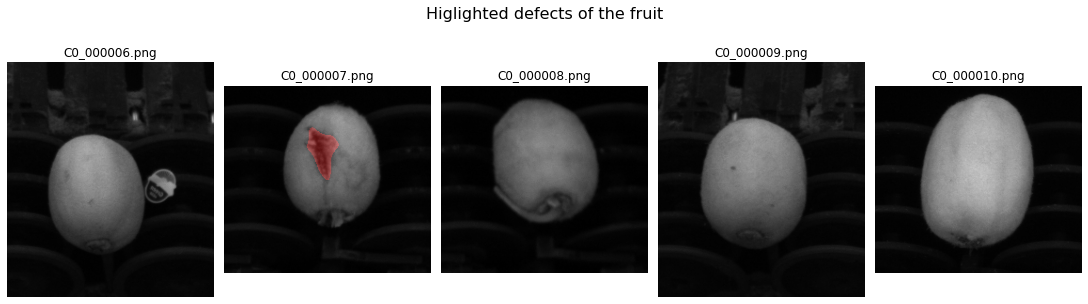

In [103]:
defect_masks = [cv2.medianBlur(m, 7) for m in defect_masks]
highlighted_defects = [get_highlighted_roi_by_mask(img, e, 'red') for img, e in zip(nir_imgs, defect_masks)]

plot_image_grid(defect_masks, nir_names, 'Cleaned-up defect masks')
plot_image_grid(highlighted_defects, nir_names, 'Higlighted defects of the fruit')

In [ ]:

contours = []

for m in masks:
    c, _ = cv.findContours(m, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours.append(c)

#plt.imshow(edge_masks[0], cmap='gray', vmin=0, vmax=255)
#plt.imshow(cv.cvtColor(c_imgs[0], cv.COLOR_BGR2RGB))
#plt.show()

#contours = [cv.findContours(m, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)[1] for m in edge_masks]

#contours = [c.astype(np.int64) for c in contours]

#print(contours[0].dtype)

In [ ]:
contoured_images = [np.copy(img) for img in colour_imgs]

In [ ]:
#cv.drawContours(contoured_images[0], contours[0], -1, (0,255,0), 3)

In [ ]:
contoured_images = [np.copy(img) for img in colour_imgs]

cv.drawContours(contoured_images[0], contours[0], -1, (0,255,0), 3)

plt.imshow(cv.cvtColor(contoured_images[0], cv.COLOR_BGR2RGB))
plt.show()

In [ ]:
max_contours = [sorted(c, key=cv.contourArea)[-1] for c in contours]

In [ ]:
contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, max_contours):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')

In [ ]:
def smooth(contour):
    k = 15
    c = cv.copyMakeBorder(contour,  (k-1) // 2, (k-1) // 2 ,0, 0, cv.BORDER_WRAP);
    return cv.blur(c, (1,k),(-1,-1));

cs = [smooth(c) for c in max_contours]

In [ ]:
contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, cs):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')

In [ ]:
contoured_images = [np.copy(img) for img in colour_imgs]

rect = cv.minAreaRect(contours[0])
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(contoured_images[0], [box], 0,(0,0,255),2)

plt.imshow(cv.cvtColor(contoured_images[0], cv.COLOR_BGR2RGB))
plt.show()

In [ ]:
'''smoothened = [cv.approxPolyDP(s, .5, True) for s in max_contours]'''


In [ ]:
'''contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, smoothened):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')''';

In [ ]:
'''def get_convexity_points(contour):
    #contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contour = contours[0]

    hull = cv2.convexHull(contour, returnPoints=False)

    points = []

    defects = cv2.convexityDefects(contour, hull)

    if defects is None:
        return points

    for i in range(defects.shape[0]):
        _, _, index, _ = defects[i, 0]
        point = tuple(contour[index][0])
        points.append(point)

    return np.array([points])''';

In [ ]:
'''conv_points = [get_convexity_points(c) for c in cs]


contoured_images = [np.copy(img) for img in colour_imgs]
print()
for img, c in zip(contoured_images, conv_points):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')''';

In [ ]:
'''convex_hulls = [cv.convexHull(c, returnPoints=False) for c in max_contours]
defects = [cv.convexityDefects(c, h) for c, h in zip(max_contours, convex_hulls)]''';

In [ ]:
'''for im, h in zip(colour_imgs, convex_hulls):
    # create an empty black image
    drawing = np.copy(im)

    # draw contours and hull points
    cv.drawContours(drawing, h, -1, (0, 255,0), 3)
    plt.imshow(cv.cvtColor(drawing, cv.COLOR_BGR2RGB))
    plt.show()
''';

In [ ]:
print(len(defects))

In [ ]:
print(defects[0][0])

In [ ]:
def ed2(lhs, rhs):
    return(lhs[0] - rhs[0])*(lhs[0] - rhs[0]) + (lhs[1] - rhs[1])*(lhs[1] - rhs[1])


def remove_from_contour(contour, defectsIdx, tmp):
    minDist = sys.maxsize
    startIdx, endIdx = 0, 0

    for i in range(0,len(defectsIdx)):
        for j in range(i+1, len(defectsIdx)):
            dist = ed2(contour[defectsIdx[i]][0], contour[defectsIdx[j]][0])
            if minDist > dist:
                minDist = dist
                startIdx = defectsIdx[i]
                endIdx = defectsIdx[j]

    if startIdx <= endIdx:
        inside = contour[startIdx:endIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:startIdx]
        outside2 = contour[endIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len2 < len1:
            startIdx,endIdx = endIdx,startIdx     
    else:
        inside = contour[endIdx:startIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:endIdx]
        outside2 = contour[startIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len1 < len2:
            startIdx,endIdx = endIdx,startIdx

    if startIdx <= endIdx:
        out = np.concatenate((contour[0:startIdx], contour[endIdx:len(contour)]), axis=0)
    else:
        out = contour[endIdx:startIdx]
    return out


def remove_defects(mask, debug=False):
    tmp = mask.copy()
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # get contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    assert len(contours) > 0, "No contours found"
    contour = sorted(contours, key=cv2.contourArea)[-1] #largest contour
    if debug:
        init = cv2.drawContours(tmp.copy(), [contour], 0, (255, 0, 255), 1, cv2.LINE_AA)
        figure, ax = plt.subplots(1)
        ax.imshow(init)
        ax.set_title("Initital Contour")

    hull = cv2.convexHull(contour, returnPoints=False)
    defects = cv2.convexityDefects(contour, hull)

    while True:
        defectsIdx = []
        
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            
            depth = d / 255
            #print(depth)
            if depth > 5:
                defectsIdx.append(f)

        if len(defectsIdx) < 2:
            break

        contour = remove_from_contour(contour, defectsIdx, tmp)
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

    if debug:
      rslt = cv2.drawContours(tmp.copy(), [contour], 0, (0, 0, 255), 2)
      figure, ax = plt.subplots(1)
      ax.imshow(rslt)
      ax.set_title("Corrected Contour")

In [ ]:
cv2 = cv

In [ ]:
remove_defects(masks[3], debug=True)